In [ ]:
# default_exp instance_segmentation

# Instance segmentation

> Instance segmentation model

In [ ]:
# export

from pathlib import Path
from typing import List, Tuple, Union, Optional, Dict, Set

In [ ]:
# exporti


import numpy as np
import os
from datetime import datetime
import torch
import torch.utils.data
from torch.hub import download_url_to_file
import torchvision
import PIL
from PIL import Image
from zipfile import ZipFile

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
#exporti

# Download TorchVision repo to use some files from
# references/detection

if not Path("vision").exists():

    !git clone https://github.com/pytorch/vision.git

    !cp vision/references/detection/utils.py .
    !cp vision/references/detection/transforms.py .
    !cp vision/references/detection/coco_eval.py .
    !cp vision/references/detection/engine.py .
    !cp vision/references/detection/coco_utils.py .

# imports
from engine import train_one_epoch, evaluate
import transforms as T
import utils

In [ ]:
for m in [np, torch, torchvision, PIL]:
    print(f"{m.__name__:12}: {m.__version__}")

numpy       : 1.18.5
torch       : 1.7.1
torchvision : 0.8.2
PIL         : 7.2.0


## Download data

In [ ]:
dataset_root = Path("./data/dolphins_200")
dataset_zip = dataset_root.parent / "dolphins_200.zip"
dataset_url = "https://s3.eu-central-1.amazonaws.com/ai-league.cisex.org/2020-2021/dolphins-instance-segmentation/dolphins_200.zip"

dataset_zip.parent.mkdir(parents=True, exist_ok=True)

if not dataset_zip.exists():
    torch.hub.download_url_to_file(
        dataset_url,
        dataset_zip,
        hash_prefix=None,
        progress=True,
    )
    

with ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_root)
    
!ls -lh {dataset_root}

total 36K
drwxr-xr-x 2 sharath sharath 12K Dec 14 14:13 JPEGImages/
drwxr-xr-x 2 sharath sharath 12K Dec 14 14:13 SegmentationClass/
drwxr-xr-x 2 sharath sharath 12K Dec 14 14:13 SegmentationObject/


## Dataset

In [ ]:
# exporti


def _enumerate_colors_for_fname(fname: Path) -> Tuple[int, int, int]:
    img = Image.open(fname)
    colors = [y for x, y in img.getcolors()]
    return colors

In [ ]:
# export


def enumerate_colors_for_fnames(fnames: List[Path]) -> List[Tuple[int, int, int]]:
    """This function is used to pin (0, 0, 0) color to the front of palette"""
    colors = np.array([_enumerate_colors_for_fname(fname) for fname in fnames]).reshape(
        -1, 3
    )
    colors = set([tuple(x) for x in colors.tolist() if tuple(x) != (0, 0, 0)])
    colors = [(0, 0, 0)] + list(colors)
    return {x: i for i, x in enumerate(colors)}

In [ ]:
# exporti


def _substitute_values(xs: np.array, x, y):
    """Not sure I understand what this does"""
    ix_x = xs == x
    ix_y = xs == y
    xs[ix_x] = y
    xs[ix_y] = x

In [ ]:
# export


def enumerate_image_for_instances(
    im: Image, force_black_to_zero: bool = True, max_colors=16
) -> np.array:
    pallete_mask = im.convert("P", palette=Image.ADAPTIVE, colors=max_colors)

    xs = np.array(pallete_mask)

    if force_black_to_zero:
        _substitute_values(xs, 0, xs.max())

    return xs

In [ ]:
# export


def enumerate_image_for_classes(
    im: Image,
    colors: Dict[Tuple[int], int] = None,
) -> np.array:
    xs = np.array(im)
    xs = [
        ((xs == color).all(axis=-1)).astype(int) * code
        for color, code in colors.items()
    ]
    xs_sum = xs[0]
    for i in range(1, len(xs)):
        xs_sum = xs_sum + xs[i]
    return xs_sum.astype("uint8")

In [ ]:
# exporti


class DolphinsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "SegmentationClass"))))
        self.instances = list(
            sorted(os.listdir(os.path.join(root, "SegmentationObject")))
        )

        fnames = [
            os.path.join(self.root, "SegmentationClass", mask) for mask in self.masks
        ]
        self.class_colors = enumerate_colors_for_fnames(fnames)

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        label_path = os.path.join(self.root, "SegmentationClass", self.masks[idx])
        mask_path = os.path.join(self.root, "SegmentationObject", self.instances[idx])

        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask_img = Image.open(mask_path)

        mask = enumerate_image_for_instances(mask_img)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        label_img = Image.open(label_path)
        label_array = enumerate_image_for_classes(label_img, self.class_colors)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        labels = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

            class_mask = label_array * masks[i]
            label, count = np.unique(class_mask, return_counts=True)
            assert label.shape[0] <= 2
            label = max(label)
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there WAS multi class
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = DolphinsDataset(dataset_root)

## Model

In [ ]:
# exporti


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True
    )  # box_score_thresh=0.5

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

#### Hint: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

In [ ]:
# exporti


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        # TODO: add additional transforms: e.g. random crop
    return T.Compose(transforms)

In [ ]:
batch_size = 4

# use our dataset and defined transformations
dataset = DolphinsDataset(dataset_root, get_transform(train=True))
dataset_test = DolphinsDataset(dataset_root, get_transform(train=False))

val_split = 0.2
n_val = max(1, round(val_split * len(dataset)))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-n_val])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-n_val:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and dolphin
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10, 35], gamma=0.1
)  # StepLR(optimizer, step_size=10, gamma=0.1) #MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
# slow

# let's train it for 50 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:00:46  lr: 0.000133  loss: 2.1840 (2.1840)  loss_classifier: 0.6545 (0.6545)  loss_box_reg: 0.2684 (0.2684)  loss_mask: 1.2175 (1.2175)  loss_objectness: 0.0323 (0.0323)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 1.1673  data: 0.6677  max mem: 4474
Epoch: [0]  [10/40]  eta: 0:00:16  lr: 0.001414  loss: 1.3187 (1.4456)  loss_classifier: 0.3436 (0.4036)  loss_box_reg: 0.2955 (0.2955)  loss_mask: 0.5938 (0.6867)  loss_objectness: 0.0144 (0.0363)  loss_rpn_box_reg: 0.0187 (0.0234)  time: 0.5354  data: 0.0666  max mem: 4751
Epoch: [0]  [20/40]  eta: 0:00:10  lr: 0.002695  loss: 1.1234 (1.1820)  loss_classifier: 0.2337 (0.2954)  loss_box_reg: 0.2760 (0.2787)  loss_mask: 0.4720 (0.5220)  loss_objectness: 0.0304 (0.0437)  loss_rpn_box_reg: 0.0187 (0.0422)  time: 0.4728  data: 0.0071  max mem: 4751
Epoch: [0]  [30/40]  eta: 0:00:04  lr: 0.003975  loss: 0.7564 (1.0341)  loss_classifier: 0.1498 (0.2442)  loss_box_reg: 0.2495 (0.2758)  loss_mask: 0.2998 (0.4410)  loss_ob

In [ ]:
# skip
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
prediction

[{'boxes': tensor([[222.2484, 224.6698, 341.7426, 273.3389],
          [344.2298, 243.7156, 467.5552, 279.7397],
          [333.9989, 226.1208, 396.2184, 258.3094],
          [291.6039, 226.8718, 343.3623, 254.1305],
          [391.3159, 243.0789, 427.6386, 259.4230],
          [355.8583, 243.4655, 427.0150, 261.2069],
          [351.9607, 228.1378, 416.0118, 261.2155],
          [298.5867, 228.0073, 376.8271, 255.4483],
          [381.9229, 229.7373, 427.6209, 259.5719],
          [314.7811, 228.4582, 488.0615, 280.0555],
          [245.4077, 252.4938, 356.3882, 273.6561],
          [315.5877, 233.5822, 426.1705, 265.9127],
          [334.3801, 239.9488, 366.0406, 258.2241],
          [295.4373, 243.2987, 371.0781, 255.5024],
          [251.9840, 227.2526, 384.0998, 260.6643],
          [267.4256, 242.5440, 432.1178, 274.7155],
          [386.4981, 242.4225, 451.6278, 275.3713],
          [340.8578, 234.3153, 371.4800, 255.8901],
          [253.6351, 260.2563, 311.7489, 273.0581],
   

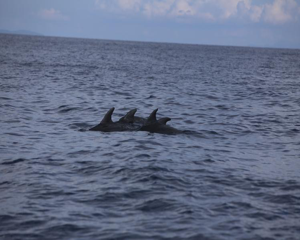

Mask for score 99.4%


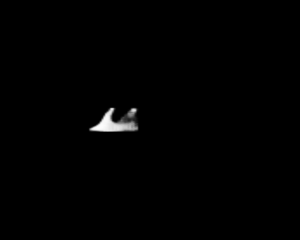

Mask for score 99.2%


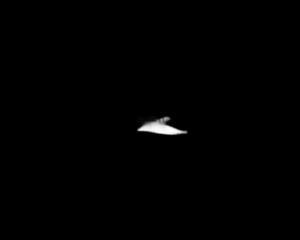

Mask for score 94.3%


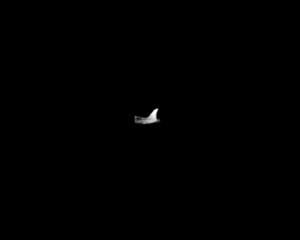

Mask for score 93.2%


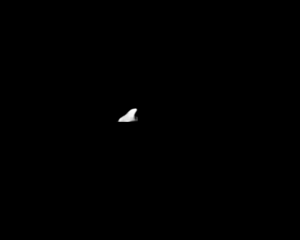

Skipping mask for score 89.2%
Skipping mask for score 88.3%
Skipping mask for score 80.0%
Skipping mask for score 75.7%
Skipping mask for score 56.3%
Skipping mask for score 47.6%
Skipping mask for score 44.9%
Skipping mask for score 34.2%
Skipping mask for score 28.8%
Skipping mask for score 28.5%
Skipping mask for score 27.8%
Skipping mask for score 27.7%
Skipping mask for score 19.4%
Skipping mask for score 19.1%
Skipping mask for score 18.9%
Skipping mask for score 16.8%
Skipping mask for score 16.1%
Skipping mask for score 15.7%
Skipping mask for score 12.6%
Skipping mask for score 11.3%
Skipping mask for score 10.2%
Skipping mask for score 9.4%
Skipping mask for score 8.1%
Skipping mask for score 7.3%
Skipping mask for score 7.2%
Skipping mask for score 7.2%
Skipping mask for score 6.9%
Skipping mask for score 6.4%
Skipping mask for score 6.3%
Skipping mask for score 6.1%
Skipping mask for score 5.9%
Skipping mask for score 5.5%
Skipping mask for score 5.1%


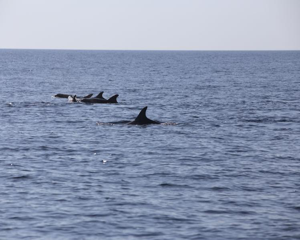

Mask for score 99.2%


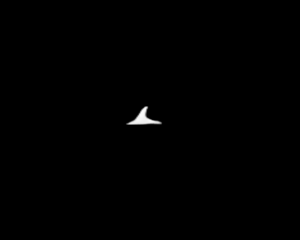

Mask for score 99.2%


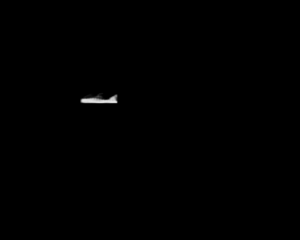

Mask for score 97.9%


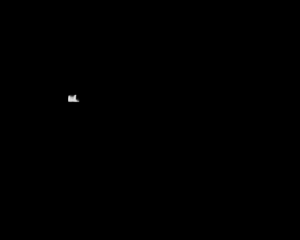

Mask for score 95.8%


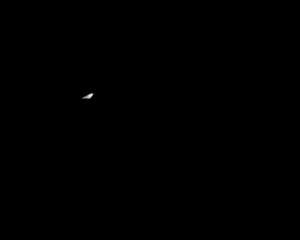

Mask for score 94.3%


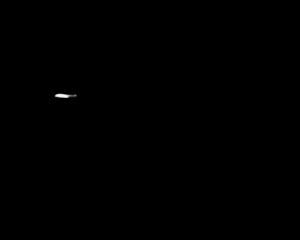

Skipping mask for score 90.0%
Skipping mask for score 86.6%
Skipping mask for score 79.1%
Skipping mask for score 75.4%
Skipping mask for score 73.0%
Skipping mask for score 66.1%
Skipping mask for score 63.5%
Skipping mask for score 61.1%
Skipping mask for score 55.7%
Skipping mask for score 52.1%
Skipping mask for score 47.2%
Skipping mask for score 46.2%
Skipping mask for score 26.1%
Skipping mask for score 21.9%
Skipping mask for score 17.9%
Skipping mask for score 17.3%
Skipping mask for score 15.0%
Skipping mask for score 12.8%
Skipping mask for score 10.9%
Skipping mask for score 7.0%
Skipping mask for score 6.4%
Skipping mask for score 5.6%
Skipping mask for score 5.4%
Skipping mask for score 5.3%


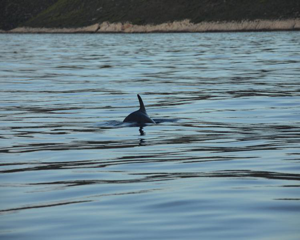

Mask for score 99.5%


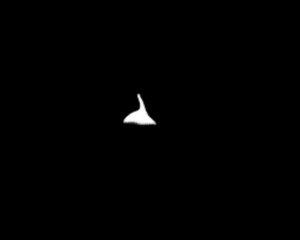

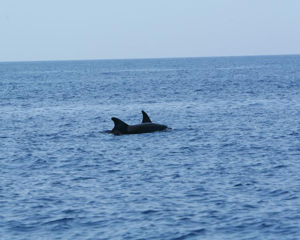

Mask for score 99.1%


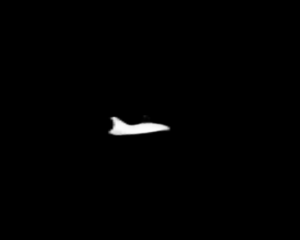

Mask for score 95.2%


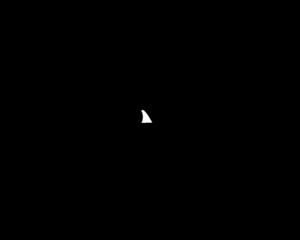

Skipping mask for score 79.3%
Skipping mask for score 6.9%
Skipping mask for score 6.8%


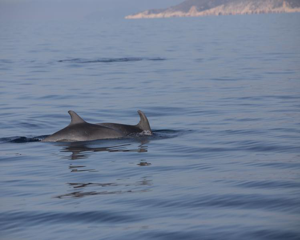

Mask for score 99.7%


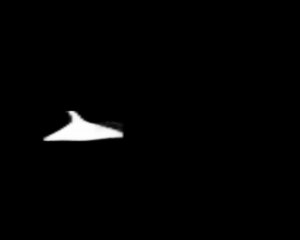

Mask for score 99.4%


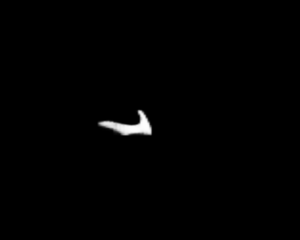

Skipping mask for score 17.1%
Skipping mask for score 10.8%
Skipping mask for score 5.6%


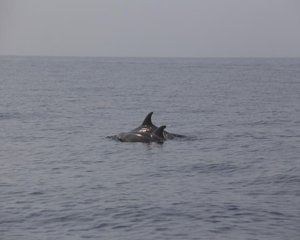

Mask for score 99.7%


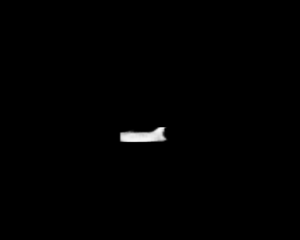

Mask for score 98.8%


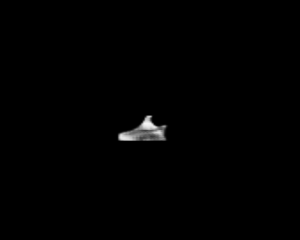

Mask for score 96.3%


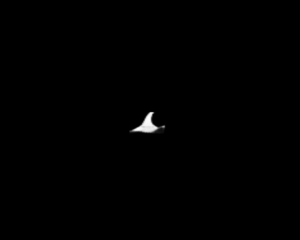

Skipping mask for score 64.5%
Skipping mask for score 17.3%
Skipping mask for score 11.7%
Skipping mask for score 9.9%
Skipping mask for score 6.0%
Skipping mask for score 5.8%


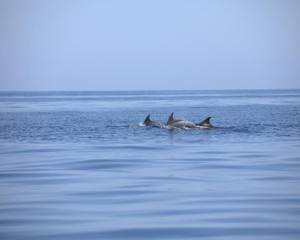

Mask for score 98.9%


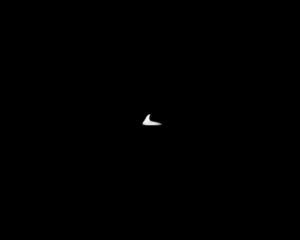

Mask for score 98.8%


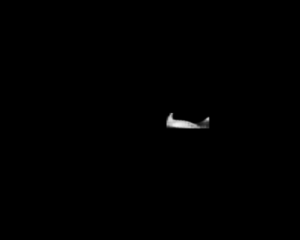

Mask for score 95.7%


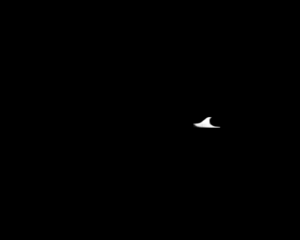

Mask for score 91.5%


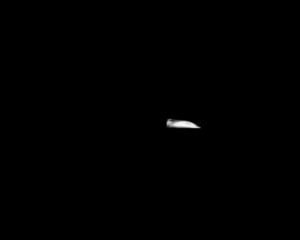

Skipping mask for score 88.4%
Skipping mask for score 58.9%
Skipping mask for score 36.9%
Skipping mask for score 32.5%
Skipping mask for score 30.7%
Skipping mask for score 29.1%
Skipping mask for score 24.3%
Skipping mask for score 24.1%
Skipping mask for score 23.5%
Skipping mask for score 21.8%
Skipping mask for score 20.9%
Skipping mask for score 20.0%
Skipping mask for score 19.8%
Skipping mask for score 18.9%
Skipping mask for score 18.3%
Skipping mask for score 18.1%
Skipping mask for score 13.3%
Skipping mask for score 9.2%
Skipping mask for score 8.4%
Skipping mask for score 8.3%
Skipping mask for score 6.6%
Skipping mask for score 5.8%
Skipping mask for score 5.3%


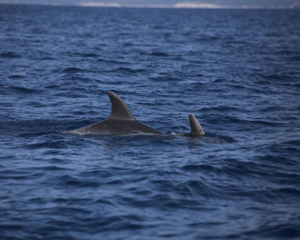

Mask for score 99.5%


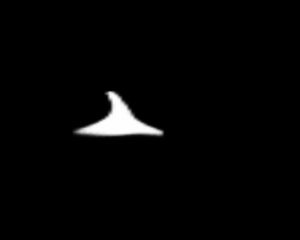

Mask for score 98.0%


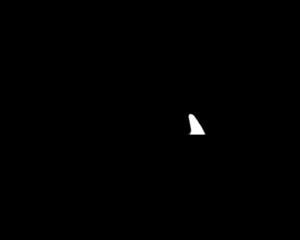

Skipping mask for score 42.0%


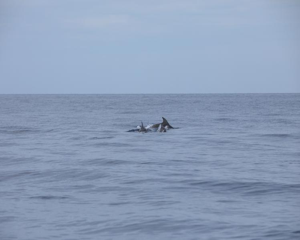

Mask for score 98.8%


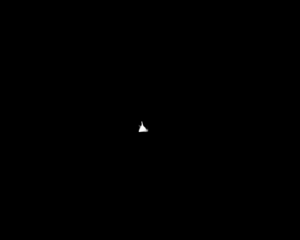

Mask for score 97.6%


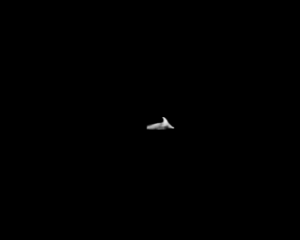

Skipping mask for score 86.9%
Skipping mask for score 86.7%
Skipping mask for score 85.1%
Skipping mask for score 81.7%
Skipping mask for score 78.0%
Skipping mask for score 77.6%
Skipping mask for score 74.0%
Skipping mask for score 71.2%
Skipping mask for score 71.1%
Skipping mask for score 50.8%
Skipping mask for score 48.9%
Skipping mask for score 47.0%
Skipping mask for score 45.7%
Skipping mask for score 28.9%
Skipping mask for score 28.9%
Skipping mask for score 25.5%
Skipping mask for score 25.0%
Skipping mask for score 24.8%
Skipping mask for score 24.1%
Skipping mask for score 22.8%
Skipping mask for score 20.5%
Skipping mask for score 20.5%
Skipping mask for score 18.9%
Skipping mask for score 15.7%
Skipping mask for score 12.8%
Skipping mask for score 12.0%
Skipping mask for score 11.6%
Skipping mask for score 11.5%
Skipping mask for score 10.9%
Skipping mask for score 9.6%
Skipping mask for score 9.1%
Skipping mask for score 9.0%
Skipping mask for score 8.5%
Skipping mask 

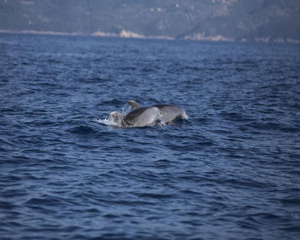

Mask for score 97.4%


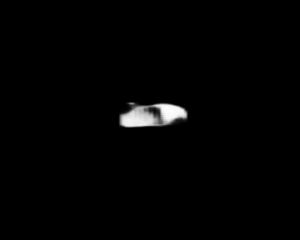

Skipping mask for score 62.3%
Skipping mask for score 30.0%
Skipping mask for score 30.0%
Skipping mask for score 28.1%
Skipping mask for score 27.0%
Skipping mask for score 12.9%
Skipping mask for score 11.0%
Skipping mask for score 8.5%
Skipping mask for score 6.1%
Skipping mask for score 6.1%


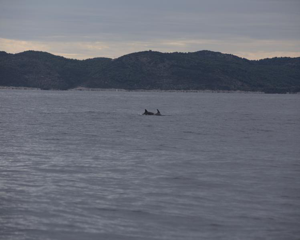

Mask for score 99.2%


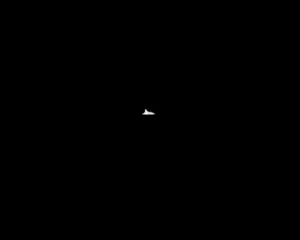

Mask for score 93.1%


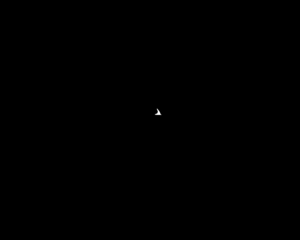

Mask for score 92.0%


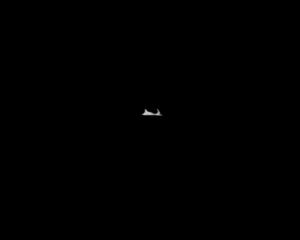

Skipping mask for score 44.6%
Skipping mask for score 38.0%
Skipping mask for score 25.7%
Skipping mask for score 16.1%
Skipping mask for score 14.8%
Skipping mask for score 11.2%
Skipping mask for score 10.0%
Skipping mask for score 9.0%
Skipping mask for score 8.5%


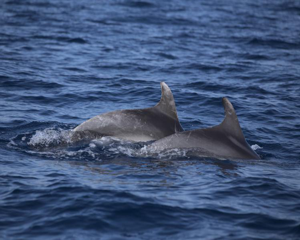

Mask for score 99.7%


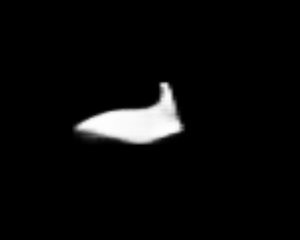

Mask for score 99.7%


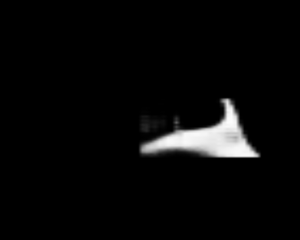

Skipping mask for score 25.6%
Skipping mask for score 20.7%
Skipping mask for score 9.5%
Skipping mask for score 5.7%


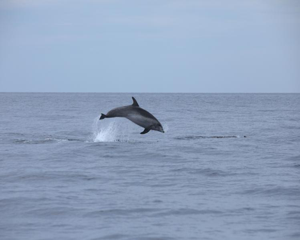

Mask for score 99.3%


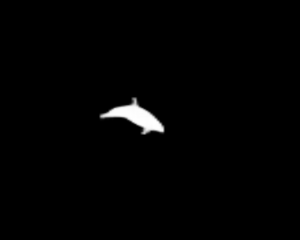

Skipping mask for score 70.3%
Skipping mask for score 55.6%
Skipping mask for score 21.7%
Skipping mask for score 19.2%
Skipping mask for score 11.1%
Skipping mask for score 10.2%
Skipping mask for score 5.7%


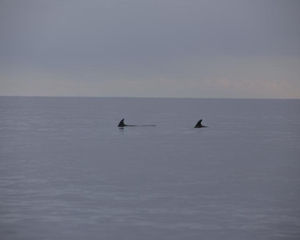

Mask for score 99.2%


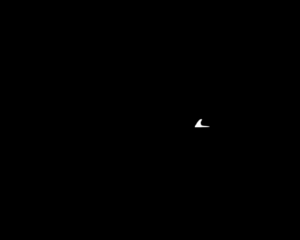

Skipping mask for score 88.5%
Skipping mask for score 85.0%
Skipping mask for score 56.4%
Skipping mask for score 17.3%
Skipping mask for score 12.1%
Skipping mask for score 10.9%
Skipping mask for score 8.3%


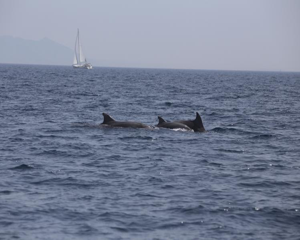

Mask for score 99.6%


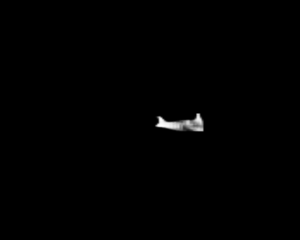

Mask for score 99.6%


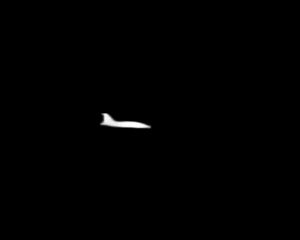

Skipping mask for score 87.5%
Skipping mask for score 75.3%
Skipping mask for score 55.1%
Skipping mask for score 21.7%
Skipping mask for score 18.8%
Skipping mask for score 17.8%
Skipping mask for score 15.9%
Skipping mask for score 15.4%
Skipping mask for score 9.0%
Skipping mask for score 8.7%
Skipping mask for score 6.8%
Skipping mask for score 6.4%
Skipping mask for score 6.1%
Skipping mask for score 5.9%


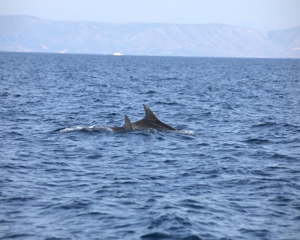

Mask for score 99.6%


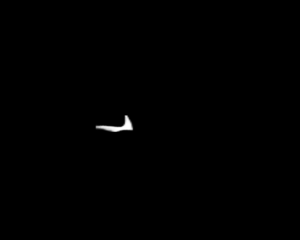

Mask for score 99.2%


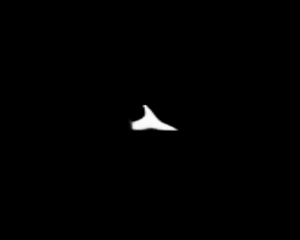

Skipping mask for score 52.8%
Skipping mask for score 24.1%
Skipping mask for score 10.0%
Skipping mask for score 7.7%
Skipping mask for score 7.0%
Skipping mask for score 5.9%
Skipping mask for score 5.9%


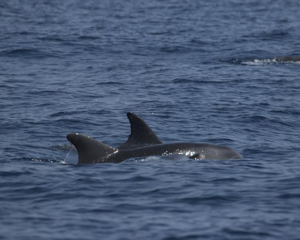

Mask for score 97.7%


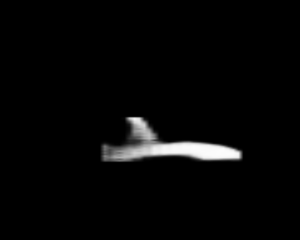

Mask for score 97.5%


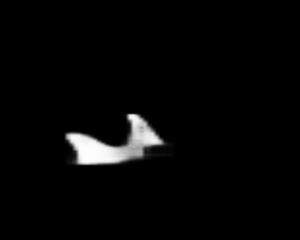

Skipping mask for score 70.8%
Skipping mask for score 66.5%
Skipping mask for score 13.4%
Skipping mask for score 6.1%


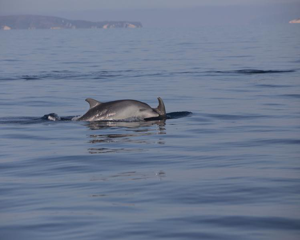

Mask for score 99.5%


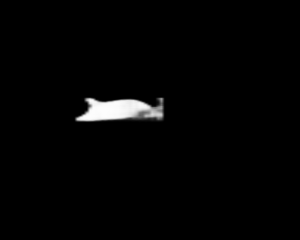

Mask for score 92.4%


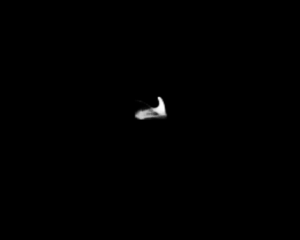

Skipping mask for score 69.6%
Skipping mask for score 37.4%
Skipping mask for score 37.1%
Skipping mask for score 28.1%
Skipping mask for score 24.7%
Skipping mask for score 14.2%
Skipping mask for score 13.3%
Skipping mask for score 12.3%
Skipping mask for score 8.9%


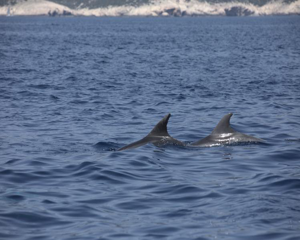

Mask for score 99.6%


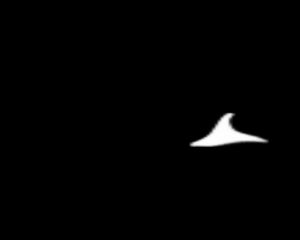

Mask for score 99.5%


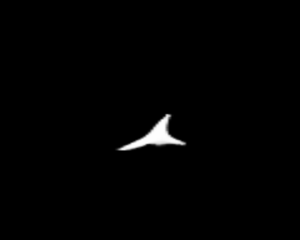

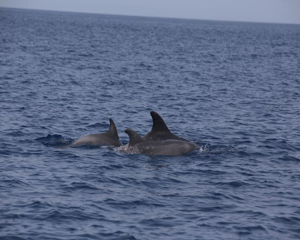

Mask for score 99.6%


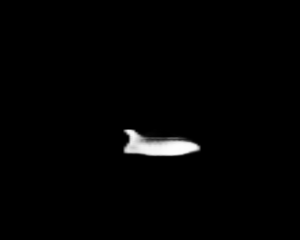

Mask for score 99.5%


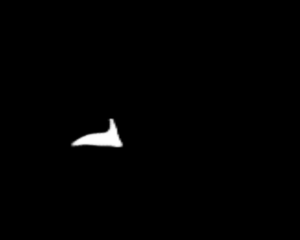

Mask for score 95.1%


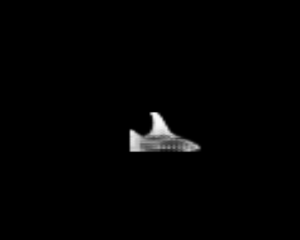

Skipping mask for score 24.1%
Skipping mask for score 18.4%
Skipping mask for score 9.9%
Skipping mask for score 7.4%
Skipping mask for score 7.3%


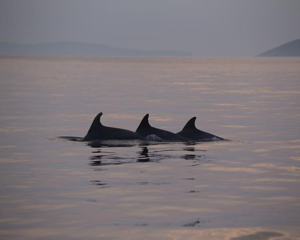

Mask for score 99.7%


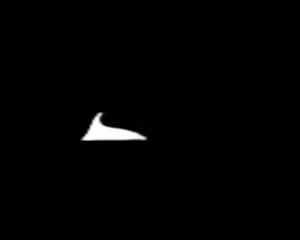

Mask for score 99.5%


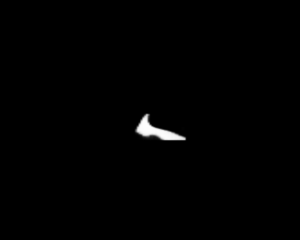

Mask for score 99.4%


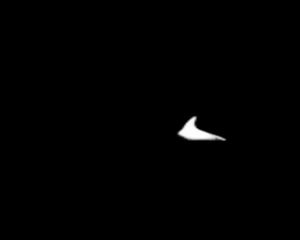

Mask for score 92.0%


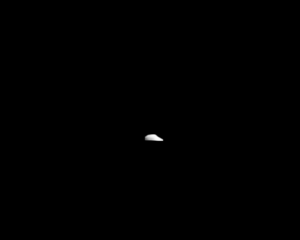

Skipping mask for score 55.8%
Skipping mask for score 32.1%
Skipping mask for score 28.1%
Skipping mask for score 16.6%
Skipping mask for score 11.3%
Skipping mask for score 8.5%
Skipping mask for score 6.8%
Skipping mask for score 5.4%


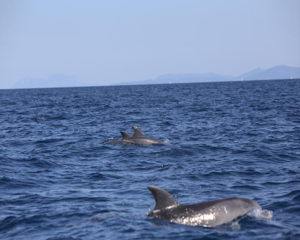

Mask for score 99.7%


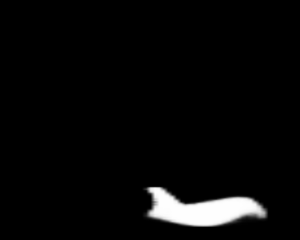

Mask for score 99.6%


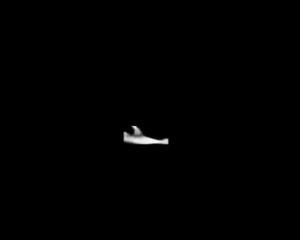

Skipping mask for score 81.8%
Skipping mask for score 72.8%
Skipping mask for score 39.2%
Skipping mask for score 36.8%
Skipping mask for score 27.5%
Skipping mask for score 26.3%
Skipping mask for score 26.0%
Skipping mask for score 18.6%
Skipping mask for score 12.3%
Skipping mask for score 9.1%
Skipping mask for score 8.2%
Skipping mask for score 8.0%
Skipping mask for score 7.6%
Skipping mask for score 7.6%
Skipping mask for score 5.2%


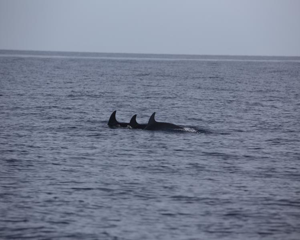

Mask for score 99.6%


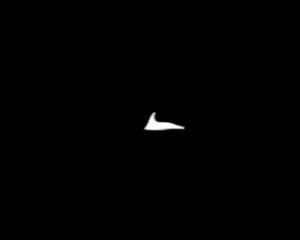

Mask for score 99.4%


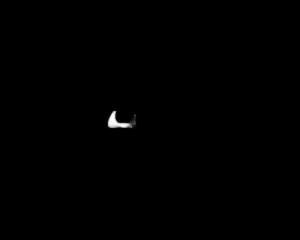

Mask for score 98.8%


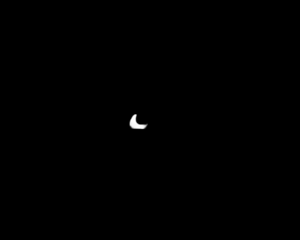

Skipping mask for score 41.7%
Skipping mask for score 12.8%
Skipping mask for score 9.0%
Skipping mask for score 6.8%
Skipping mask for score 5.6%
Skipping mask for score 5.3%


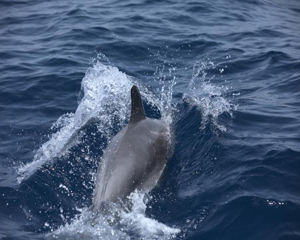

Mask for score 98.2%


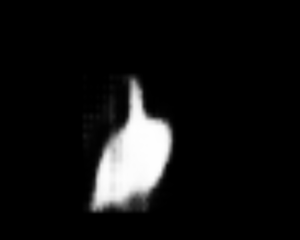

Skipping mask for score 84.3%
Skipping mask for score 42.6%
Skipping mask for score 27.0%
Skipping mask for score 7.7%


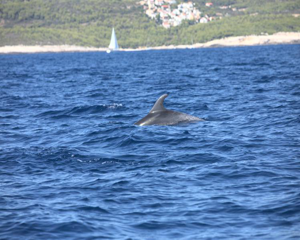

Mask for score 99.6%


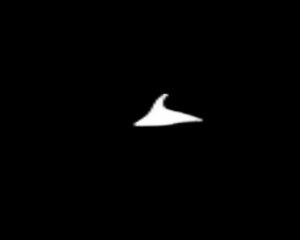

Skipping mask for score 88.8%
Skipping mask for score 8.4%


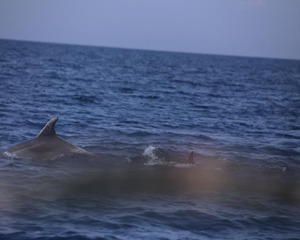

Mask for score 99.3%


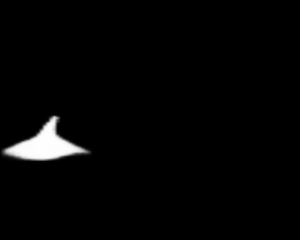

Skipping mask for score 88.1%
Skipping mask for score 82.6%
Skipping mask for score 46.7%
Skipping mask for score 42.1%
Skipping mask for score 40.5%
Skipping mask for score 6.2%
Skipping mask for score 6.0%
Skipping mask for score 5.0%


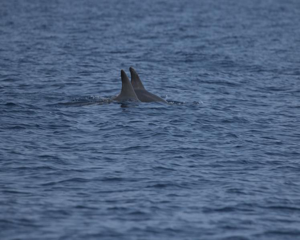

Mask for score 99.6%


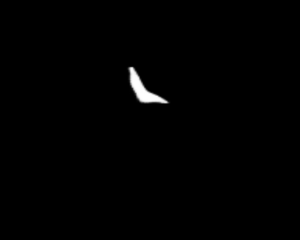

Mask for score 99.2%


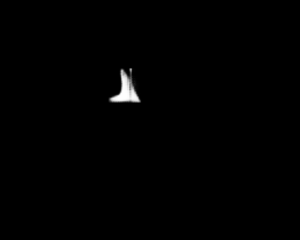

Skipping mask for score 28.7%


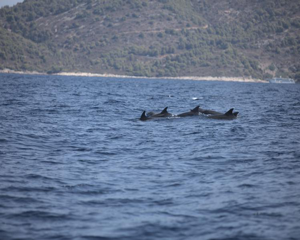

Mask for score 99.1%


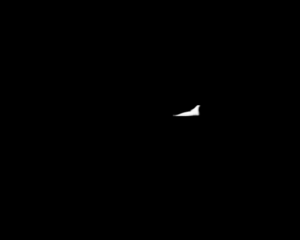

Mask for score 98.7%


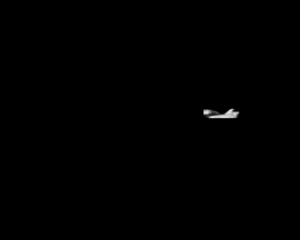

Mask for score 98.3%


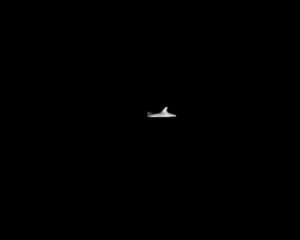

Mask for score 97.2%


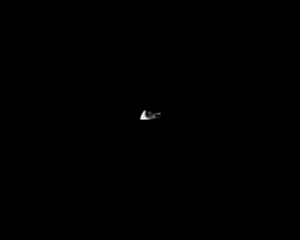

Mask for score 95.9%


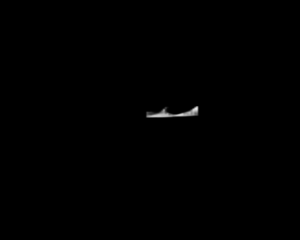

Skipping mask for score 84.0%
Skipping mask for score 70.3%
Skipping mask for score 63.9%
Skipping mask for score 59.9%
Skipping mask for score 58.8%
Skipping mask for score 47.8%
Skipping mask for score 41.6%
Skipping mask for score 37.4%
Skipping mask for score 34.4%
Skipping mask for score 31.4%
Skipping mask for score 24.8%
Skipping mask for score 24.5%
Skipping mask for score 23.1%
Skipping mask for score 21.9%
Skipping mask for score 16.3%
Skipping mask for score 8.2%
Skipping mask for score 6.7%
Skipping mask for score 6.6%
Skipping mask for score 6.4%
Skipping mask for score 5.8%
Skipping mask for score 5.6%
Skipping mask for score 5.4%
Skipping mask for score 5.2%


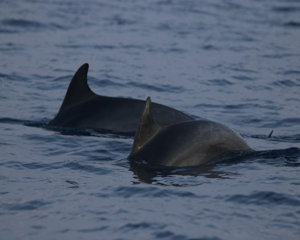

Mask for score 99.3%


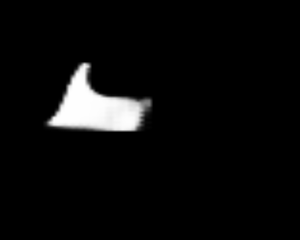

Mask for score 99.3%


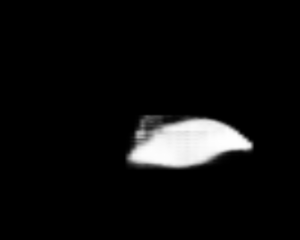

Mask for score 95.4%


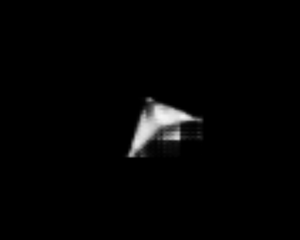

Skipping mask for score 88.0%
Skipping mask for score 69.6%
Skipping mask for score 50.7%
Skipping mask for score 47.8%
Skipping mask for score 45.7%
Skipping mask for score 33.8%
Skipping mask for score 22.0%
Skipping mask for score 18.5%
Skipping mask for score 13.4%
Skipping mask for score 9.9%


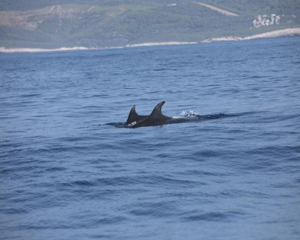

Mask for score 99.3%


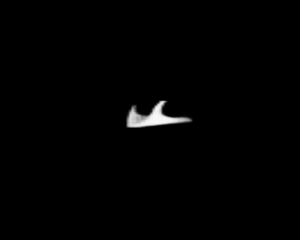

Skipping mask for score 40.9%
Skipping mask for score 9.9%
Skipping mask for score 8.8%


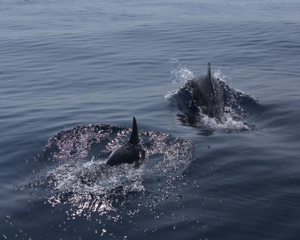

Mask for score 99.1%


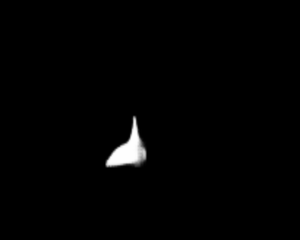

Mask for score 97.7%


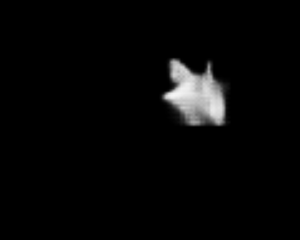

Skipping mask for score 75.9%
Skipping mask for score 55.8%
Skipping mask for score 37.4%
Skipping mask for score 21.1%
Skipping mask for score 14.3%
Skipping mask for score 12.1%
Skipping mask for score 8.1%
Skipping mask for score 5.4%


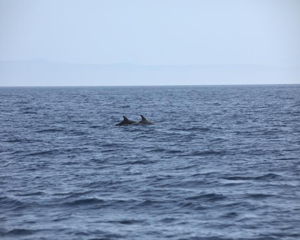

Mask for score 99.1%


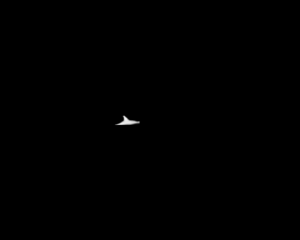

Mask for score 98.6%


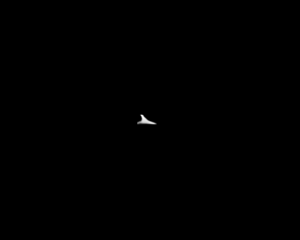

Skipping mask for score 60.0%
Skipping mask for score 54.6%
Skipping mask for score 32.6%
Skipping mask for score 32.6%
Skipping mask for score 21.9%
Skipping mask for score 19.1%
Skipping mask for score 18.3%
Skipping mask for score 10.5%
Skipping mask for score 7.7%


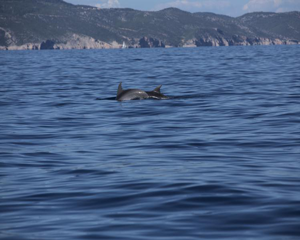

Mask for score 99.6%


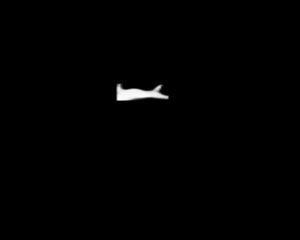

Skipping mask for score 52.1%
Skipping mask for score 41.6%
Skipping mask for score 31.6%
Skipping mask for score 31.0%
Skipping mask for score 27.2%
Skipping mask for score 22.3%
Skipping mask for score 11.8%
Skipping mask for score 9.2%
Skipping mask for score 8.4%
Skipping mask for score 7.8%
Skipping mask for score 6.3%
Skipping mask for score 6.1%


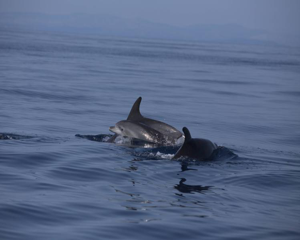

Mask for score 99.4%


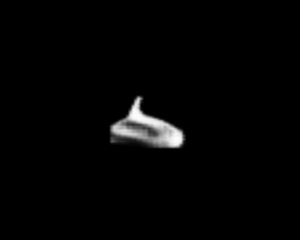

Mask for score 97.7%


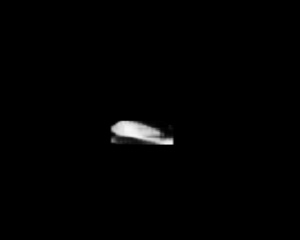

Mask for score 97.6%


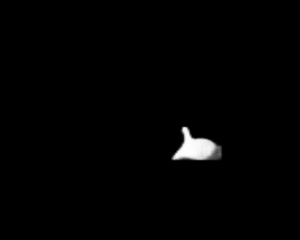

Skipping mask for score 45.7%
Skipping mask for score 33.8%
Skipping mask for score 25.1%
Skipping mask for score 22.0%
Skipping mask for score 21.4%
Skipping mask for score 16.0%
Skipping mask for score 9.4%
Skipping mask for score 8.2%
Skipping mask for score 5.6%


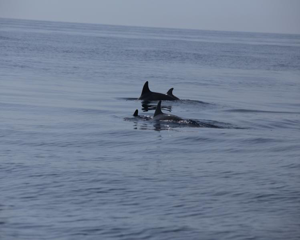

Mask for score 99.6%


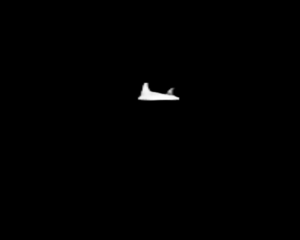

Mask for score 99.0%


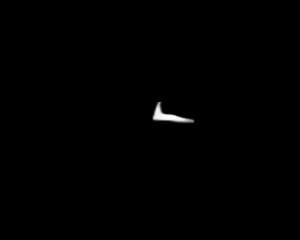

Skipping mask for score 85.2%
Skipping mask for score 69.4%
Skipping mask for score 67.0%
Skipping mask for score 50.3%
Skipping mask for score 42.8%
Skipping mask for score 21.4%
Skipping mask for score 20.5%
Skipping mask for score 10.6%
Skipping mask for score 10.3%
Skipping mask for score 8.0%
Skipping mask for score 7.9%
Skipping mask for score 7.8%
Skipping mask for score 7.0%
Skipping mask for score 6.7%
Skipping mask for score 6.4%
Skipping mask for score 5.9%
Skipping mask for score 5.3%
Skipping mask for score 5.1%


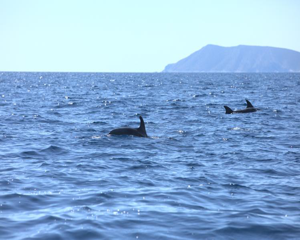

Mask for score 99.7%


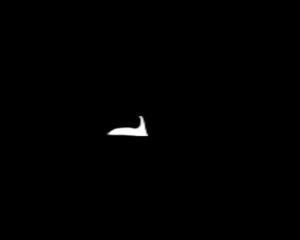

Mask for score 98.9%


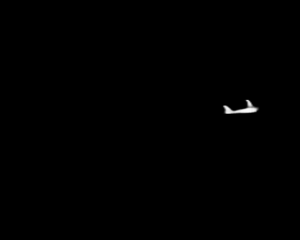

Skipping mask for score 77.2%
Skipping mask for score 63.6%
Skipping mask for score 24.5%
Skipping mask for score 9.4%
Skipping mask for score 7.0%


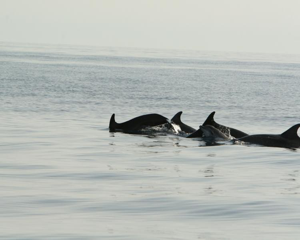

Mask for score 99.3%


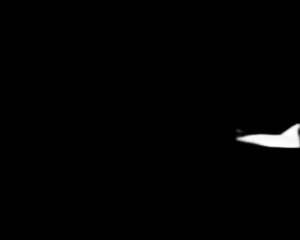

Mask for score 99.1%


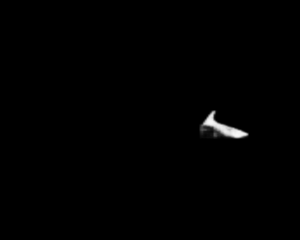

Mask for score 99.1%


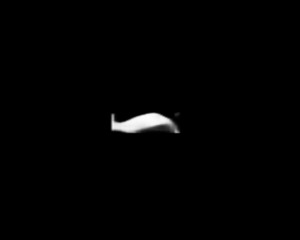

Mask for score 99.0%


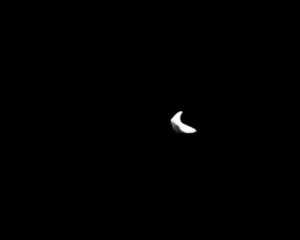

Mask for score 98.4%


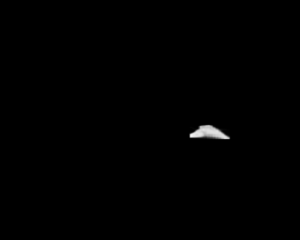

Skipping mask for score 87.4%
Skipping mask for score 63.4%
Skipping mask for score 41.0%
Skipping mask for score 31.0%
Skipping mask for score 28.4%
Skipping mask for score 27.4%
Skipping mask for score 23.8%
Skipping mask for score 18.9%
Skipping mask for score 18.2%
Skipping mask for score 17.9%
Skipping mask for score 15.6%
Skipping mask for score 14.1%
Skipping mask for score 14.0%
Skipping mask for score 8.5%
Skipping mask for score 8.3%
Skipping mask for score 6.0%
Skipping mask for score 5.5%


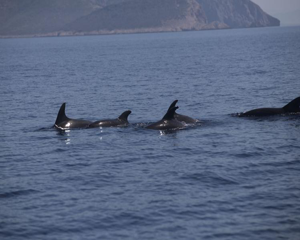

Mask for score 99.6%


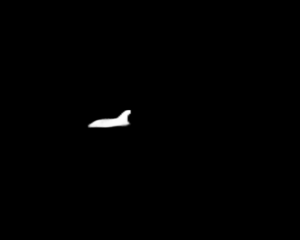

Mask for score 99.4%


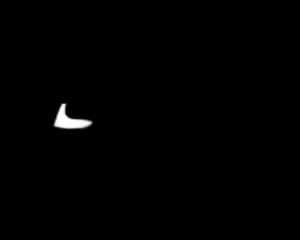

Mask for score 99.2%


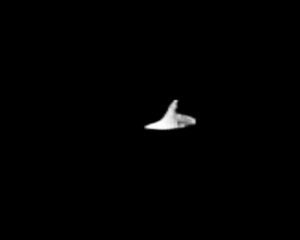

Mask for score 98.8%


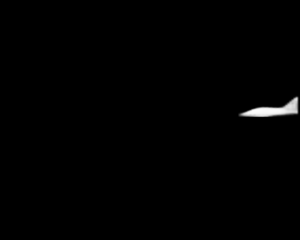

Skipping mask for score 42.1%
Skipping mask for score 36.1%
Skipping mask for score 34.6%
Skipping mask for score 29.7%
Skipping mask for score 27.6%
Skipping mask for score 11.4%
Skipping mask for score 6.8%
Skipping mask for score 6.7%
Skipping mask for score 6.2%
Skipping mask for score 5.9%


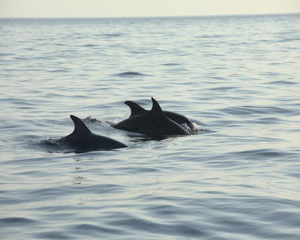

Mask for score 99.7%


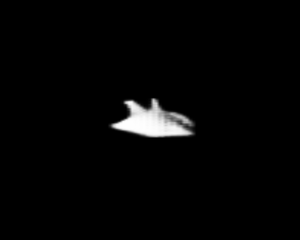

Mask for score 99.4%


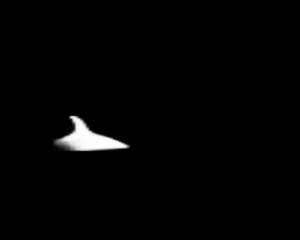

Skipping mask for score 19.7%
Skipping mask for score 15.2%
Skipping mask for score 6.4%
Skipping mask for score 5.0%


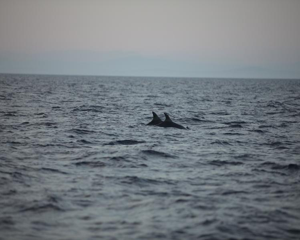

Mask for score 98.7%


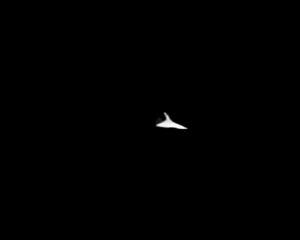

Mask for score 97.7%


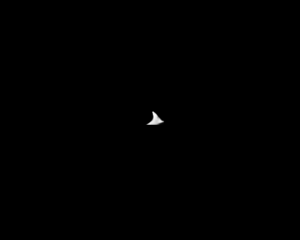

Skipping mask for score 23.0%
Skipping mask for score 22.0%
Skipping mask for score 10.8%
Skipping mask for score 5.5%


In [ ]:
# exporti


def _show_pred(dataset_test, n=None):
    if n == None:
        n = len(dataset_test)

    for i in range(n):
        img = dataset_test[i][0]
        display(
            Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()).resize(
                (300, 240)
            )
        )
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])
        predicted_masks = prediction[0]["masks"]
        scores = prediction[0]["scores"]

        for i in range(predicted_masks.shape[0]):
            score = scores[i]
            if score > 0.9:
                print(f"Mask for score {score:.1%}")
                display(
                    Image.fromarray(
                        predicted_masks[i, 0].mul(255).byte().cpu().numpy()
                    ).resize((300, 240))
                )
            else:
                print(f"Skipping mask for score {score:.1%}")


_show_pred(dataset_test)

In [ ]:
# exporti


def _save_model_with_timestamp(
    model, save_path="/work/data/dupini/processed/body_100_resized/"
):
    save_date_path = (
        save_path + "model" + datetime.now().strftime("-%Y-%m-%d-%H-%M-%S") + ".pt"
    )
    print(save_date_path)
    torch.save(model.state_dict(), save_date_path)

In [ ]:
# _save_model_with_timestamp(model)

## Calculate metrics

In [ ]:
## todo

In [ ]:
i = 1
img = dataset_test[i][0]
gt_label = dataset_test[i][1]["masks"]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
predicted_masks = prediction[0]["masks"]
predicted_masks_np = predicted_masks[i, 0].cpu().numpy()  # .astype('bool')
# list1 = encode_binary_mask(predicted_masks_np)

In [ ]:
gt_boxes = dataset_test[i][1]["boxes"][3,:].cpu().numpy()

In [ ]:
pred_boxes = prediction[0]["boxes"][i,:].cpu().numpy()

In [ ]:
predicted_masks_np.shape

(500, 749)

In [ ]:



def iou_metric(binary_segmentation, binary_gt_label):
    """
    Compute the IOU between two binary segmentation.
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        IOU: IOU between the segmentation and the ground truth
    """

    # turn all variables to booleans, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=np.bool)
    binary_gt_label = np.asarray(binary_gt_label, dtype=np.bool)

    # compute the intersection
    intersection = np.logical_and(binary_segmentation, binary_gt_label)
    union = np.logical_or(binary_segmentation, binary_gt_label)
    # count the number of True pixels in the binary segmentation
    segmentation_pixels = float(np.sum(binary_segmentation.flatten()))
    # same for the ground truth
    gt_label_pixels = float(np.sum(binary_gt_label.flatten()))
    # same for the intersection and union
    intersection = float(np.sum(intersection.flatten()))
    union = float(np.sum(union.flatten()))
    # compute the Dice coefficient
    smooth = 0.001
    IOU = (intersection + smooth)/ (union + smooth)

    # return it
    return IOU

In [ ]:
def dice_coefficient(binary_segmentation, binary_gt_label):
    """
    Compute the Dice coefficient between two binary segmentation.
    Dice coefficient is defined as here: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        dice_value: Dice coefficient between the segmentation and the ground truth
    """

    # turn all variables to booleans, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=np.bool)
    binary_gt_label = np.asarray(binary_gt_label, dtype=np.bool)

    # compute the intersection
    intersection = np.logical_and(binary_segmentation, binary_gt_label)

    # count the number of True pixels in the binary segmentation
    segmentation_pixels = float(np.sum(binary_segmentation.flatten()))
    # same for the ground truth
    gt_label_pixels = float(np.sum(binary_gt_label.flatten()))
    # same for the intersection
    intersection = float(np.sum(intersection.flatten()))

    # compute the Dice coefficient
    dice_value = 2 * intersection / (segmentation_pixels + gt_label_pixels)

    # return it
    return dice_value

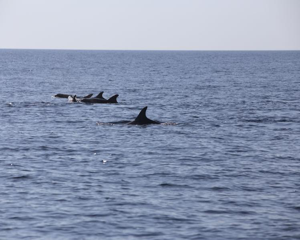

In [ ]:
display(
    Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()).resize((300, 240))
)

In [ ]:
binary_mask_gt = gt_label.permute(1, 2, 0).cpu().numpy()
# print(binary_mask_gt.shape)
print(
    "Dice coefficient:", dice_coefficient(binary_mask_gt[:, :, 3], predicted_masks_np)
    )
print(
    "IOU:", iou_metric(binary_mask_gt[:, :, 3], predicted_masks_np)
)

Dice coefficient: 0.613222612583839
IOU: 0.44219279493652924


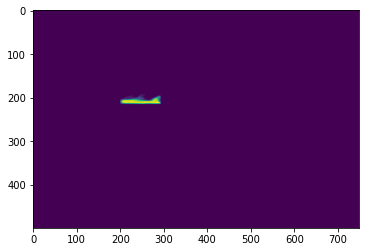

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(predicted_masks_np)

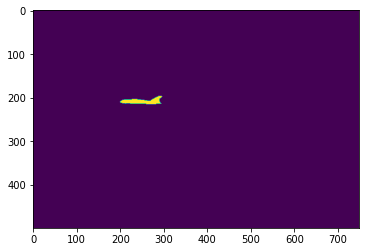

In [ ]:
plt.imshow(binary_mask_gt[:, :, 3])

## Submission of results


In [ ]:
## todo

In [ ]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""  # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s"
            % mask.dtype
        )
        mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape
        )  # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)  # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0][
        "counts"
    ]  # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return encoded_mask

In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

In [ ]:
list1 = mask2rle(predicted_masks_np)

In [ ]:
def rle2mask(mask_rle, shape=(749, 500)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

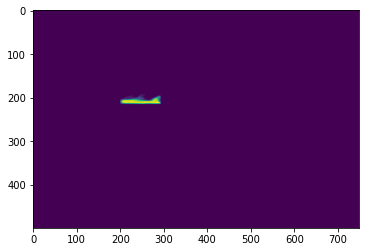

In [ ]:
plt.imshow(predicted_masks_np)

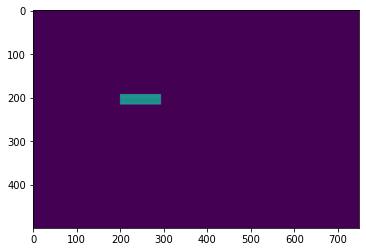

In [ ]:
plt.imshow(rle2mask(list1))

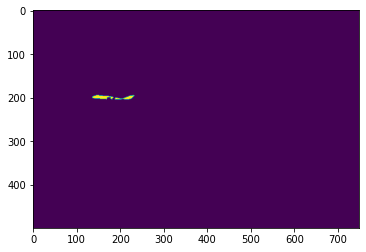

In [ ]:
plt.imshow(gt_label[2, :, :])

In [ ]:
rle_gt_mask = mask2rle(binary_mask_gt[:, :, 3])
rle_pred_mask = mask2rle(predicted_masks_np)

In [ ]:
import pandas as pd

gt_df = pd.DataFrame(np.array([['im1.png',gt_boxes, 500, 749]]), columns=['Id', 'Expected', 'width', 'height'] )
pred_df = pd.DataFrame(np.array([['im1.png',pred_boxes]]), columns=['Id', 'Predicted'] )

In [ ]:
gt_df.to_csv('Solutions.csv',index=False)

In [ ]:
pred_df.to_csv('Submission.csv',index=False)

In [ ]:
pred_df

Id                                    Predicted width height
0  im1.png  [202.11217, 193.8881, 292.72385, 214.59444]   500    749